## Semantic segmentation: Road/Lane detection on driving scene




1.   <a href='#Intro'>Introduction</a>
1.   <a href='#Init_env'>Setting environment</a>
2.    <a href='#data_load'>Load training and validation data</a>
1.    <a href='#fcn32'>Build first model: FCN32</a>
2.   <a href='#fcn8'>Build second model: FCN8</a>
1.   <a href='#fcn_compare'>Compare both models</a>
2.   <a href='#conclusion'>Conclusion & Next steps</a>











<a name='Intro'></a>
## Introduction

<img src="https://raw.githubusercontent.com/sunshineatnoon/Paper-Collection/master/images/FCN1.png">

For the purpose of efficiently detecting road boundaries in a driving scene, we apply a semantic segmentation algorithm: **FCN8** and **FCN32** on the [Kitti dataset](http://www.cvlibs.net/datasets/kitti/eval_road.php).  
[FCN for semantic segmentation](https://arxiv.org/pdf/1605.06211.pdf) were introduced by Long et Al. In this notebook, we implement the method suggested in the paper to classify each pixel in the scene:  
1.   Fine tune an exising classification model by adding a Upsampling layer to it (FCN32 model)
2.   Add skip layers to the trained model to "**make local predictions that respect the global structure**" (prediction cited from the paper).  
The 2 models we build are using VGG16 classification network. For that purpose it's necessary to download [VGG16 pretrained weights without top layers for keras](https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5).  
Below is a overview of the architure of the fcn32 models:  
![FCN32 Architecture](images/fcn32_architecture.png)


<a name='Init_env'></a>
## Setting environment

### Install dependencies and check presence of GPU

In [1]:
!pip install PyDrive #get files from gdrive

    100% |████████████████████████████████| 993kB 21.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [2]:
import os.path
import tensorflow as tf
import warnings
from distutils.version import LooseVersion
from google.colab import files
import shutil
import keras

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
# check keras version
print("Keras version: "+keras.__version__)

Using TensorFlow backend.


Default GPU Device: /device:GPU:0
Keras version: 2.2.4


### Import code, training data and vgg model

In [0]:
from google.colab import files
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import time

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Importing VGG16 weights:

In [0]:
weights=drive.CreateFile({'id':'1uyOrTF7oxL2dyFQh9iQ81hIzPJlEl2KH'})
weights.GetContentFile('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

Import data:

In [0]:
dataset=drive.CreateFile({'id':'1v4CQv1Q3eag8xRwG1cgbcD-CXjzJHmXu'})
dataset.GetContentFile('data_road.zip')
zip_ref = zipfile.ZipFile("data_road.zip",'r')
zip_ref.extractall()
zip_ref.close()

Import utilities files fcn32 model and fcn8 model if any

In [0]:
utils_file=drive.CreateFile({'id':'10YDp9U3I3r2XAMJD3IGedbthY0aZZ4de'})
utils_file.GetContentFile('ss_utils.py')
import ss_utils

In [0]:
fcn32=drive.CreateFile({'id':'19pCbgniAOIILJ7nlAzfDxQNtu5gTQx_Y'})
fcn32.GetContentFile('fcn32.h5')

In [0]:
fcn8=drive.CreateFile({'id':'1_IuGHgD7_4hwmaw-KxV63rsOLS03WDnx'})
fcn8.GetContentFile('fcn8.h5')

### Parameters and imports

In [0]:
import os
import numpy as np
import cv2
import itertools
from glob import glob
import re
import random
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras import models
from keras import layers
from keras.utils import plot_model
from keras import optimizers
from keras.models import load_model
import matplotlib.pyplot as plt
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build
from keras import backend as K
from glob import glob

In [0]:
base_dir='data_road'
train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'testing')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
IMAGE_ORDERING = 'channels_first'
InputHeight=160
InputWidth=576
img_input = Input(shape=(InputHeight,InputWidth,3))
nClasses=2
drive_service = build('drive', 'v3')

<a name='data_load'></a>
## Load training data and validation data

In [0]:
train_images,train_labels=ss_utils.get_data(train_dir, nClasses ,InputHeight, InputWidth)
val_images,val_labels=ss_utils.get_data(val_dir, nClasses, InputHeight, InputWidth)
train_Aug_lab,train_Aug_im=ss_utils.augment_training_data(train_images,train_labels,nClasses,InputHeight,InputWidth)
print('training samples: '+str(len(train_images)))
print('validation samples: '+str(len(val_images)))
print('training samples after augmentation: '+str(len(train_Aug_lab)))

training samples: 255
validation samples: 34
training samples after augmentation: 510


<a name='fcn32'></a>
## FCN32 model

Load vgg16 weights with no FC layers then add to our models architecture.
It's important to freeze vgg16 weights.

In [0]:
fcn32model=ss_utils.fcn32(nClasses,'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',InputHeight,InputWidth)
fcn32model.summary()
fcn32model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 160, 576, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 576, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 576, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 288, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 288, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)

Now we fit the model:

In [0]:
history = fcn32model.fit(x=train_Aug_im, y=train_Aug_lab,
                    epochs=20,
                    batch_size=10,
                    validation_data=(val_images, val_labels))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 510 samples, validate on 34 samples
Epoch 1/20
510/510 [==============================] - 54s 106ms/step - loss: 0.5445 - acc: 0.6891 - val_loss: 0.3267 - val_acc: 0.8497
Epoch 2/20
510/510 [==============================] - 44s 87ms/step - loss: 0.2388 - acc: 0.8934 - val_loss: 0.2034 - val_acc: 0.9102
Epoch 3/20
510/510 [==============================] - 44s 87ms/step - loss: 0.1725 - acc: 0.9248 - val_loss: 0.2091 - val_acc: 0.9095
Epoch 4/20
510/510 [==============================] - 44s 87ms/step - loss: 0.1516 - acc: 0.9339 - val_loss: 0.1685 - val_acc: 0.9260
Epoch 5/20
510/510 [==============================] - 45s 87ms/step - loss: 0.1331 - acc: 0.9426 - val_loss: 0.1616 - val_acc: 0.9285
Epoch 6/20
510/510 [==============================] - 44s 87ms/step - loss: 0.1218 - acc: 0.9477 - val_loss: 0.1633 - val_acc: 0.9292
Epoch 7/20
510/510 [====

Vizualize training and validation loss

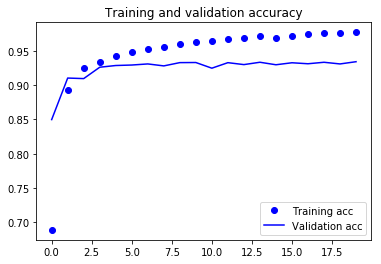

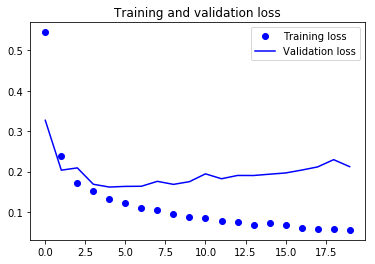

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Save model to gdrive

In [0]:
fcn32model.save('fcn32.h5')
ss_utils.save_file_to_drive(drive_service,"fcn32.h5", "fcn32.h5")

File ID: 19pCbgniAOIILJ7nlAzfDxQNtu5gTQx_Y


{'id': '19pCbgniAOIILJ7nlAzfDxQNtu5gTQx_Y'}

<a name='fcn8'></a>
## FCN8 model

**If we're retraining an existing then go** <a href='#Retraining_block'>here</a>. 
Else, we load saved fcn32 model and add skip layers to compose our FCN8 model


In [0]:
fcn32= load_model('fcn32.h5')

In [0]:
fcn8model=ss_utils.fcn8(fcn32model,nClasses)
fcn8model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'])
plot_model(fcn8model)
fcn8model.summary()

/content/ss_utils.py:164: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  M = Model(input=fcnmodel.input, output=x)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 576, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 160, 576, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 160, 576, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 80, 288, 64)  0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

<a name='Retraining_block'></a>
**If we need to retrain the model** then come directly here.

In [0]:
fcn8model=load_model('fcn8.h5')

For any retrain operation several operations are possible such as resetting the learning rate below.  
This section we keep commented.

In [0]:
# K.set_value(fcn8model.optimizer.lr, 0.00001)

Once we compile the model (or load a trained one for retraining) then we fit it

In [0]:
history = fcn8model.fit(x=train_Aug_im, y=train_Aug_lab,
                    epochs=20,
                    batch_size=10,
                    validation_data=(val_images, val_labels))

Train on 510 samples, validate on 34 samples
Epoch 1/20
510/510 [==============================] - 85s 167ms/step - loss: 0.0711 - acc: 0.9706 - val_loss: 0.1015 - val_acc: 0.9584
Epoch 2/20
510/510 [==============================] - 75s 147ms/step - loss: 0.0691 - acc: 0.9713 - val_loss: 0.1001 - val_acc: 0.9589
Epoch 3/20
510/510 [==============================] - 75s 148ms/step - loss: 0.0658 - acc: 0.9727 - val_loss: 0.1049 - val_acc: 0.9578
Epoch 4/20
510/510 [==============================] - 75s 147ms/step - loss: 0.0652 - acc: 0.9729 - val_loss: 0.1049 - val_acc: 0.9573
Epoch 5/20
510/510 [==============================] - 75s 148ms/step - loss: 0.0635 - acc: 0.9735 - val_loss: 0.1031 - val_acc: 0.9594
Epoch 6/20
510/510 [==============================] - 75s 147ms/step - loss: 0.0611 - acc: 0.9745 - val_loss: 0.0967 - val_acc: 0.9607
Epoch 7/20
510/510 [==============================] - 75s 148ms/step - loss: 0.0601 - acc: 0.9749 - val_loss: 0.1005 - val_acc: 0.9595
Epoch 8/20

Visualize loss

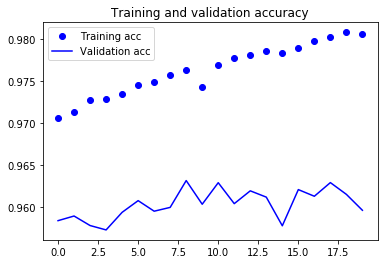

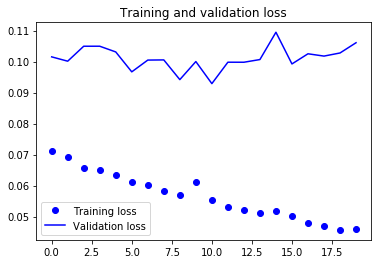

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Save to gdrive

In [0]:
fcn8model.save('fcn8.h5')
ss_utils.save_file_to_drive(drive_service,"fcn8.h5", "fcn8.h5")

File ID: 1_IuGHgD7_4hwmaw-KxV63rsOLS03WDnx


{'id': '1_IuGHgD7_4hwmaw-KxV63rsOLS03WDnx'}

<a name='fcn_compare'></a>
## Comparing both models

Load models

In [0]:
fcn8model=load_model('fcn8.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
fcn32model=load_model('fcn32.h5')

We select some random images and compare performance for both models

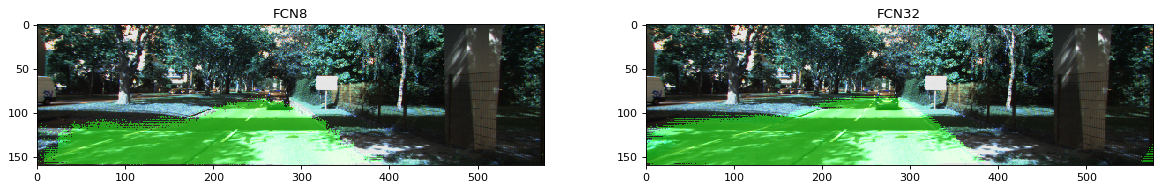

<Figure size 432x288 with 0 Axes>

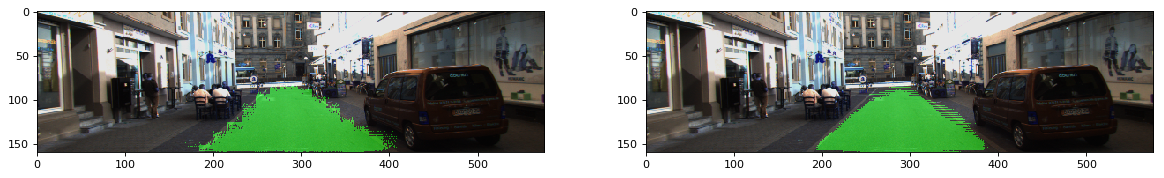

<Figure size 432x288 with 0 Axes>

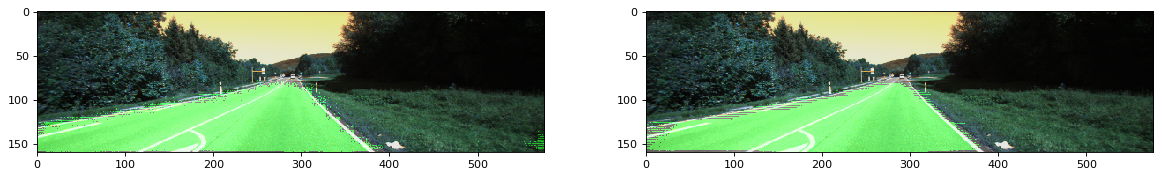

In [0]:
%matplotlib inline
plt.rcParams["axes.grid"] = False

image_paths = glob(os.path.join('data_road/training/', 'image_2', '*.png'))
nImages=3
idx=np.random.choice(len(image_paths),size=nImages)
for i,id in enumerate(idx):
  imgName=image_paths[id]
  outName = os.path.join('predictions',os.path.basename(imgName))
  im0 = cv2.imread(imgName, 1)
  im,seg_img=ss_utils.fcn_predict(fcn8model,im0,nClasses,InputHeight,InputWidth)
  fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
  if i==0: plt.subplot(1, 2, 1).set_title('FCN8')
  else: plt.subplot(1, 2, 1)
  plt.imshow(cv2.addWeighted(im,0.9,seg_img,0.5,0))
  if i==0: plt.subplot(1, 2, 2).set_title('FCN32')
  else: plt.subplot(1, 2, 2)
  im,seg_img2=ss_utils.fcn_predict(fcn32model,im0,nClasses,InputHeight,InputWidth)
  plt.imshow(cv2.addWeighted(im,0.9,seg_img2,0.5,0))
  if i==(len(idx)-1): plt.show()
  else: plt.figure()

<a name='conclusion'></a>
## Conclusion & Next steps